In [1]:
!pip install statsmodels patsy

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.genmod.bayes_mixed_glm import PoissonBayesMixedGLM
from tqdm import tqdm
from patsy import dmatrices
from patsy import dmatrix
from statsmodels.discrete.count_model import ZeroInflatedPoisson

In [3]:
hourly_averages = pd.read_csv('./hourly_averages.csv')

In [4]:
# Create array of category names as they appear in the detections data. See paper for details of each category.
categories = ['car', 'person', 'trotro', 'stall', 'truck', 'stove', 'motorcycle', 'vendor', 'lorry', 'umbrella', 'bus', 'trash', 'taxi', 'van', 'debris', 'loudspeaker', 'bowl', 'food', 'animal', 'bicycle']

# Column names in the data frame for the number of counts of each category type in an image.
count_cols = [cat+'_counts' for cat in categories]

super_count_cols = ['people'+'_counts', 'small_vehicles'+'_counts', 'two_wheelers'+'_counts', 'large_vehicles'+'_counts', 'refuse'+'_counts', 'market'+'_counts', 'animal'+'_counts']

all_count_cols = count_cols + super_count_cols

vehicle_categories = ['car', 'trotro', 'truck', 'motorcycle', 'lorry', 'bus', 'taxi', 'van', 'bicycle']

# Define super categories
super_categories = {
    'people': ['person', 'vendor'],
    'small_vehicles': ['car', 'taxi', 'truck'],
    'two_wheelers': ['bicycle', 'motorcycle'],
    'large_vehicles': ['trotro', 'van', 'lorry', 'bus'],
    'refuse': ['trash', 'debris'],
    'market': ['umbrella', 'stall', 'bowl', 'food'],
    'animal': ['animal']
}

In [5]:
len(hourly_averages['directory_pair'].unique())
len(hourly_averages[hourly_averages['site_id']=='N1W']['directory_pair'].unique())

508

In [32]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Decide whether to include "week" as a variable or not
week_bool = True

site = 'N1W'

if site == None:
    filtered_data = hourly_averages.copy()
else:
    filtered_data = hourly_averages[hourly_averages['site_id']==site].copy()
# filtered_data = hourly_averages[hourly_averages['people_counts'] > 0].copy()

super_category='people'
# Step 2: Create the endogenous variable (response variable)
endog = filtered_data[super_category+'_counts'].astype(int)

# Step 3: Convert relevant columns to categorical
filtered_data['hour'] = filtered_data['hour'].astype('category')
filtered_data['day'] = filtered_data['day'].astype('category')
if week_bool == True:
    filtered_data['week'] = filtered_data['week'].astype('category')
if not (site == None):
    filtered_data['site_id'] = filtered_data['site_id'].astype('category')
filtered_data['year'] = filtered_data['year'].astype('category')
filtered_data['directory_pair'] = filtered_data['directory_pair'].astype('category')

# Step 4: One-hot encode 'hour', 'day', 'week', 'site_id', and 'year' for fixed effects
if week_bool == True:
    if site == None:
        exog_fixed = pd.get_dummies(filtered_data[['hour', 'day', 'week', 'site_id', 'year','directory_pair']], drop_first=True)
    else:
        exog_fixed = pd.get_dummies(filtered_data[['hour', 'day', 'week', 'year','directory_pair']], drop_first=True)
else:
    if site == None:
        exog_fixed = pd.get_dummies(filtered_data[['hour', 'day', 'site_id', 'year','directory_pair']], drop_first=True)
    else:
        exog_fixed = pd.get_dummies(filtered_data[['hour', 'day', 'year','directory_pair']], drop_first=True)

# Step 5: Add intercept
exog_fixed = sm.add_constant(exog_fixed)

# Step 6: Convert exog_fixed to float
exog_fixed = exog_fixed.astype(float)

# Step 7: Fit the GLM with a Negative Binomial family
glm_model = sm.GLM(endog, exog_fixed, family=sm.families.NegativeBinomial())
# glm_model = sm.GLM(endog, exog_fixed, family=sm.families.Poisson())
glm_result = glm_model.fit()

# Step 8: Display the results of the fixed effects
print(glm_result.summary())



/opt/conda/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


                 Generalized Linear Model Regression Results                  
Dep. Variable:          people_counts   No. Observations:                39925
Model:                            GLM   Df Residuals:                    39331
Model Family:        NegativeBinomial   Df Model:                          593
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.4819e+05
Date:                Mon, 12 Aug 2024   Deviance:                       7903.9
Time:                        12:13:31   Pearson chi2:                 7.08e+03
No. Iterations:                    21   Pseudo R-squ. (CS):             0.6115
Covariance Type:            nonrobust                                         
                                                                                                                                                      coef    std err          z      P>|z|      [0.025      0.975

In [27]:
import statsmodels.api as sm
import statsmodels.discrete.count_model as cm
import pandas as pd
import numpy as np

# Placeholder for storing results for each site
site_results = {}

# Decide whether to include "week" as a variable or not
week_bool = True

# Step 1: Fit the model to all sites simultaneously (excluding 'directory_pair')
print("Fitting model to all sites simultaneously...")

filtered_data = hourly_averages.copy()
super_category = 'people'

# Create the endogenous variable (response variable)
endog_all_sites = filtered_data[super_category + '_counts'].astype(int)

# Convert relevant columns to categorical
filtered_data['hour'] = filtered_data['hour'].astype('category')
filtered_data['day'] = filtered_data['day'].astype('category')
if week_bool:
    filtered_data['week'] = filtered_data['week'].astype('category')
filtered_data['site_id'] = filtered_data['site_id'].astype('category')
filtered_data['year'] = filtered_data['year'].astype('category')

# Exclude 'directory_pair' from the all-site model
exog_all_sites = pd.get_dummies(filtered_data[['hour', 'day', 'week', 'site_id', 'year']], drop_first=True)

# Add intercept
exog_all_sites = sm.add_constant(exog_all_sites)
exog_all_sites = exog_all_sites.astype(float)

# Fit the GLM with a Negative Binomial family
try:
    glm_model_all_sites = sm.GLM(endog_all_sites, exog_all_sites, family=sm.families.NegativeBinomial())
    glm_result_all_sites = glm_model_all_sites.fit()

    # Store the parameters (excluding 'site_id' coefficients)
    all_site_params = glm_result_all_sites.params
    non_site_id_params = all_site_params[~all_site_params.index.str.contains('site_id')].copy()

    # Extract alpha (dispersion parameter)
    alpha = glm_result_all_sites.scale
    print(f"Estimated alpha (dispersion): {alpha}")
    
    print("\nAll-site model fitted successfully.\n")
except Exception as e:
    print(f"Error fitting model to all sites: {e}")
    non_site_id_params = None
    alpha = 1.0  # Default alpha if fitting fails

# Step 2: Fit site-specific models
if non_site_id_params is not None:
    unique_sites = ['AD']  # Debugging with only one site
    for site in unique_sites:
        print(f"Processing site: {site}")

        filtered_data_site = hourly_averages[hourly_averages['site_id'] == site].copy()

        # Create the endogenous variable (response variable)
        endog_site = filtered_data_site[super_category + '_counts'].astype(int)

        # Convert relevant columns to categorical
        filtered_data_site['hour'] = filtered_data_site['hour'].astype('category')
        filtered_data_site['day'] = filtered_data_site['day'].astype('category')
        if week_bool:
            filtered_data_site['week'] = filtered_data_site['week'].astype('category')
        filtered_data_site['year'] = filtered_data_site['year'].astype('category')
        filtered_data_site['directory_pair'] = filtered_data_site['directory_pair'].astype('category')

        # One-hot encode the categorical variables
        exog_fixed = pd.get_dummies(filtered_data_site[['hour', 'day', 'week', 'year', 'directory_pair']], drop_first=True)

        # Add intercept
        exog_fixed = sm.add_constant(exog_fixed)
        exog_fixed = exog_fixed.astype(float)

        # Initialize start_params with zeros, double the size for ZINB plus one for alpha
        num_params = exog_fixed.shape[1]
        start_params = np.zeros(2 * num_params + 1)  # Double the parameters for ZINB plus alpha

        # Fit the GLM (Negative Binomial) model first
        try:
            glm_model_site = sm.GLM(endog_site, exog_fixed, family=sm.families.NegativeBinomial())
            glm_result_site = glm_model_site.fit()

            # Extract parameters to use as starting values for ZINB model
            site_params = glm_result_site.params

            # Populate the start_params with site_params only for hour, day, week, and year in the count part
            for param_name, param_value in site_params.items():
                if param_name in exog_fixed.columns and 'directory_pair' not in param_name:
                    start_params[exog_fixed.columns.get_loc(param_name)] = param_value

            # Set the last parameter to the estimated alpha (dispersion parameter)
            start_params[-1] = alpha

            print(f"\nGLM model fitted successfully for site: {site}. Now fitting ZINB model using these parameters as start values...\n")

        except Exception as e:
            print(f"GLM model failed for site {site}: {e}")

            # Use the adjusted all-site model parameters as starting values
            try:
                print(f"Attempting to fit site-specific ZINB model for site {site} using all-site parameters as start values...")

                # Populate the start_params with non_site_id_params in the correct order for the count part
                for param_name, param_value in non_site_id_params.items():
                    if param_name in exog_fixed.columns and 'directory_pair' not in param_name:
                        start_params[exog_fixed.columns.get_loc(param_name)] = param_value

                # Set the last parameter to the estimated alpha (dispersion parameter)
                start_params[-1] = alpha

            except Exception as e:
                print(f"Failed to create start parameters for ZINB model for site {site}: {e}")
                continue  # Skip to the next site if we can't even create start parameters

        # Set directory_pair coefficients to zero in both count and inflation parts
        for col in exog_fixed.columns:
            if 'directory_pair' in col:
                start_params[exog_fixed.columns.get_loc(col)] = 0.0
                start_params[exog_fixed.columns.get_loc(col) + num_params] = 0.0  # Corresponding inflation part

        # Debugging output: print the start parameters and their alignment with exog_fixed
        print(f"Start params for site {site}: {start_params}")
        print(f"Exog_fixed columns: {exog_fixed.columns}")
        print(f"Length of start_params: {len(start_params)}")
        print(f"Length of exog_fixed columns: {len(exog_fixed.columns)}")

        # Ensure that the start_params and exog_fixed match in terms of length (excluding alpha)
        if len(start_params) != 2 * len(exog_fixed.columns) + 1:
            print(f"Mismatch in start_params and exog_fixed lengths for site {site}: "
                  f"{len(start_params)} vs {2 * len(exog_fixed.columns) + 1}")
            continue  # Skip to the next site if there's a mismatch

        # Fit the Zero-Inflated Negative Binomial model with the created start parameters
        try:
            # Ensure start_params has correct length
            if start_params.shape[0] != 2 * exog_fixed.shape[1] + 1:
                raise ValueError(f"start_params length mismatch: expected {2 * exog_fixed.shape[1] + 1}, got {start_params.shape[0]}")

            # First attempt to fit with Nelder-Mead to stabilize the parameters
            zinb_model_site = cm.ZeroInflatedNegativeBinomialP(endog_site, exog_fixed, exog_infl=exog_fixed, inflation='logit')
            zinb_result_site = zinb_model_site.fit(start_params=start_params, method='nm', maxiter=200, disp=1)

            # Refine the fit with L-BFGS-B for better accuracy
            zinb_result_site = zinb_model_site.fit(start_params=zinb_result_site.params, method='lbfgs', maxiter=500, disp=1)

            site_results[site] = zinb_result_site

            print(f"\nZINB model fitted successfully for site: {site}.\n")

        except Exception as e:
            print(f"Failed to fit ZINB model for site {site}: {e}")
else:
    print("All-site model fitting failed. No site-specific models attempted.")


Fitting model to all sites simultaneously...


/opt/conda/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


Estimated alpha (dispersion): 1.0

All-site model fitted successfully.

Processing site: AD


/opt/conda/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "



GLM model fitted successfully for site: AD. Now fitting ZINB model using these parameters as start values...

Start params for site AD: [-0.85018485 -0.25290305 -0.51088541 ...  0.          0.
  1.        ]
Exog_fixed columns: Index(['const', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6',
       'hour_7', 'hour_8', 'hour_9',
       ...
       'directory_pair_AD_30_10_2020_C17_S34|AD_30_10_2020_C4_S20',
       'directory_pair_AD_30_12_2022_C17_S46|AD_30_12_2022_C4_S30',
       'directory_pair_AD_31_01_2020_C17_S34|AD_31_01_2020_C4_S42',
       'directory_pair_AD_31_03_2023_C17_S100|AD_31_03_2023_C4_S65',
       'directory_pair_AD_31_05_2019_C14_S31|AD_31_05_2019_C17_S11',
       'directory_pair_AD_31_05_2019_C17_S11',
       'directory_pair_AD_31_07_2020_C17_S22',
       'directory_pair_AD_31_07_2020_C17_S22|AD_31_07_2020_C4_S51',
       'directory_pair_AD_31_12_2020_C17_S85|AD_31_12_2020_C4_S16',
       'directory_pair_AD_31_12_2021_C17_S44|AD_31_12_2021_C4_S20'],
      d

/opt/conda/lib/python3.11/site-packages/statsmodels/base/optimizer.py:736: RuntimeWarning: Maximum number of iterations has been exceeded.
  retvals = optimize.fmin(f, start_params, args=fargs, xtol=xtol,

KeyboardInterrupt



In [21]:
import statsmodels.api as sm
import statsmodels.discrete.count_model as cm
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Placeholder for storing results for each site
site_results = {}
glm_site_results = {}

# Decide whether to include "week" as a variable or not
week_bool = True
site_bool = True  # Assume you want to analyze all sites

# Set the model type: "poisson" or "zbinom"
model_type = "zbinom"  # Change this to "poisson" for Zero-Inflated Poisson

super_category = 'people'

# If site_bool is True, analyze each site separately
if site_bool:
    # unique_sites = hourly_averages['site_id'].unique()
    unique_sites = ['AD']
    # 1. Train the initial GLM models for each site
    for site in unique_sites:
        print(f"Processing site: {site} (GLM)")

        filtered_data = hourly_averages[hourly_averages['site_id'] == site].copy()

        # Step 2: Create the endogenous variable (response variable)
        endog = filtered_data[super_category + '_counts'].astype(int)

        # Step 3: Convert relevant columns to categorical
        filtered_data['hour'] = filtered_data['hour'].astype('category')
        filtered_data['day'] = filtered_data['day'].astype('category')
        if week_bool:
            filtered_data['week'] = filtered_data['week'].astype('category')
        filtered_data['year'] = filtered_data['year'].astype('category')
        filtered_data['directory_pair'] = filtered_data['directory_pair'].astype('category')

        # Step 4: One-hot encode 'hour', 'day', 'week', 'year', and 'directory_pair' for fixed effects
        if week_bool:
            exog_fixed = pd.get_dummies(filtered_data[['hour', 'day', 'week', 'year', 'directory_pair']], drop_first=True)
        else:
            exog_fixed = pd.get_dummies(filtered_data[['hour', 'day', 'year', 'directory_pair']], drop_first=True)

        # Step 5: Add intercept
        exog_fixed = sm.add_constant(exog_fixed)

        # Step 6: Convert exog_fixed to float
        exog_fixed = exog_fixed.astype(float)

        # Check for NaNs or Infs before modeling
        if endog.isna().sum() > 0 or np.any(np.isnan(exog_fixed)) or np.any(np.isinf(exog_fixed)):
            print(f"Skipping site {site} due to NaNs or Infs.")
            continue

        try:
            glm_model = sm.GLM(endog, exog_fixed, family=sm.families.NegativeBinomial())
            glm_result = glm_model.fit()

            glm_site_results[site] = glm_result

            print(f"\nGLM Results for site: {site}")
            print(glm_result.summary())

        except Exception as e:
            print(f"Error fitting GLM model for site {site}: {e}")
            continue

    # 2. Fit the zero-inflated models for each site, initializing with GLM results
    for site in unique_sites:
        if site in glm_site_results:  # Check if GLM model was successfully fit
            print(f"Processing site: {site} (Zero-Inflated)")

            filtered_data = hourly_averages[hourly_averages['site_id'] == site].copy()

            # Step 2: Create the endogenous variable (response variable)
            endog = filtered_data[super_category + '_counts'].astype(int)

            # Step 3: Convert relevant columns to categorical
            filtered_data['hour'] = filtered_data['hour'].astype('category')
            filtered_data['day'] = filtered_data['day'].astype('category')
            if week_bool:
                filtered_data['week'] = filtered_data['week'].astype('category')
            filtered_data['year'] = filtered_data['year'].astype('category')
            filtered_data['directory_pair'] = filtered_data['directory_pair'].astype('category')

            # Step 4: One-hot encode 'hour', 'day', 'week', 'year', and 'directory_pair' for fixed effects
            if week_bool:
                exog_fixed = pd.get_dummies(filtered_data[['hour', 'day', 'week', 'year', 'directory_pair']], drop_first=True)
            else:
                exog_fixed = pd.get_dummies(filtered_data[['hour', 'day', 'year', 'directory_pair']], drop_first=True)

            # Step 5: Add intercept
            exog_fixed = sm.add_constant(exog_fixed)

            # Step 6: Convert exog_fixed to float
            exog_fixed = exog_fixed.astype(float)

            # Check for NaNs or Infs before modeling
            if endog.isna().sum() > 0 or np.any(np.isnan(exog_fixed)) or np.any(np.isinf(exog_fixed)):
                print(f"Skipping site {site} due to NaNs or Infs.")
                continue

            try:
                if model_type == "poisson":
                    model = cm.ZeroInflatedPoisson(endog, exog_fixed, exog_infl=exog_fixed, inflation='logit')
                elif model_type == "zbinom":
                    model = cm.ZeroInflatedNegativeBinomialP(endog, exog_fixed, exog_infl=exog_fixed, inflation='logit')
                else:
                    raise ValueError("Invalid model type. Choose 'poisson' or 'zbinom'.")

                # Extract and pass initial values from GLM result
                glm_result = glm_site_results[site]
    
                # Handle 'alpha' separately (if applicable)
                if 'alpha' in model.exog_names:
                    initial_params['alpha'] = glm_result.scale  # Assuming glm_result.scale is the dispersion parameter
    
                # Initialize other parameters from GLM, handling potential case sensitivity
                for param_name in glm_result.params.index:
                    inflated_param_name = "inflate_" + param_name.lower()  # Convert to lowercase for comparison
                    if inflated_param_name in model.exog_names:
                        initial_params[inflated_param_name] = glm_result.params[param_name]
    
                # Ensure initial_params has the correct length
                if len(initial_params) != len(model.exog_names):
                    print(f"Warning: Mismatch in number of parameters for site {site}.")
                    # You might need to further investigate and adjust the initialization here
    
                # Pass initial parameters as a list to start_params
                result = model.fit(start_params=list(initial_params.values()), method='nm', maxiter=50, disp=1)

                site_results[site] = result

                print(f"\nZero-Inflated Results for site: {site}")
                print(result.summary())

            except Exception as e:
                print(f"Error fitting Zero-Inflated model for site {site}: {e}")
                continue
        else:
            print(f"Skipping Zero-Inflated model for site {site} as GLM failed to converge.")


Processing site: AD (GLM)


/opt/conda/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "



GLM Results for site: AD
                 Generalized Linear Model Regression Results                  
Dep. Variable:          people_counts   No. Observations:                40200
Model:                            GLM   Df Residuals:                    39615
Model Family:        NegativeBinomial   Df Model:                          584
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.6306e+05
Date:                Tue, 13 Aug 2024   Deviance:                       14202.
Time:                        12:59:42   Pearson chi2:                 1.25e+04
No. Iterations:                    14   Pseudo R-squ. (CS):             0.8544
Covariance Type:            nonrobust                                         
                                                                                                                                coef    std err          z      P>|z|      [0.025      0

In [11]:
import statsmodels.api as sm
import statsmodels.discrete.count_model as cm
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Placeholder for storing results for each site
site_results = {}

# Decide whether to include "week" as a variable or not
week_bool = True
site_bool = True  # Assume you want to analyze all sites

# Set the model type: "poisson" or "zbinom"
model_type = "zbinom"  # Change this to "poisson" for Zero-Inflated Poisson

super_category = 'people'

# If site_bool is True, analyze each site separately
if site_bool:
    unique_sites = hourly_averages['site_id'].unique()
    for site in unique_sites:
        print(f"Processing site: {site}")
        
        filtered_data = hourly_averages[hourly_averages['site_id'] == site].copy()
        
        # Step 2: Create the endogenous variable (response variable)
        endog = filtered_data[super_category + '_counts'].astype(int)
        
        # Step 3: Convert relevant columns to categorical
        filtered_data['hour'] = filtered_data['hour'].astype('category')
        filtered_data['day'] = filtered_data['day'].astype('category')
        if week_bool:
            filtered_data['week'] = filtered_data['week'].astype('category')
        filtered_data['year'] = filtered_data['year'].astype('category')
        filtered_data['directory_pair'] = filtered_data['directory_pair'].astype('category')
        
        # Step 4: One-hot encode 'hour', 'day', 'week', 'year', and 'directory_pair' for fixed effects
        if week_bool:
            exog_fixed = pd.get_dummies(filtered_data[['hour', 'day', 'week', 'year', 'directory_pair']], drop_first=True)
        else:
            exog_fixed = pd.get_dummies(filtered_data[['hour', 'day', 'year', 'directory_pair']], drop_first=True)
        
        # Step 5: Add intercept
        exog_fixed = sm.add_constant(exog_fixed)
        
        # Step 6: Convert exog_fixed to float
        exog_fixed = exog_fixed.astype(float)
        
        # Check for NaNs or Infs before modeling
        if endog.isna().sum() > 0 or np.any(np.isnan(exog_fixed)) or np.any(np.isinf(exog_fixed)):
            print(f"Skipping site {site} due to NaNs or Infs.")
            continue
        
        # Step 7: Conditionally fit the chosen model
        try:
            if model_type == "poisson":
                model = cm.ZeroInflatedPoisson(endog, exog_fixed, exog_infl=exog_fixed, inflation='logit')
            elif model_type == "zbinom":
                model = cm.ZeroInflatedNegativeBinomialP(endog, exog_fixed, exog_infl=exog_fixed, inflation='logit')
            else:
                raise ValueError("Invalid model type. Choose 'poisson' or 'zbinom'.")

            result = model.fit(method='nm', maxiter=50, disp=1)

            # Store results
            site_results[site] = result

            # Step 8: Display the results of the fixed effects for each site
            print(f"\nResults for site: {site}")
            print(result.summary())

        except Exception as e:
            print(f"Error fitting model for site {site}: {e}")
            continue  # Skip to the next site

else:
    # If not analyzing per site, run the model for the whole dataset
    filtered_data = hourly_averages.copy()
    
    endog = filtered_data[super_category + '_counts'].astype(int)
    
    filtered_data['hour'] = filtered_data['hour'].astype('category')
    filtered_data['day'] = filtered_data['day'].astype('category')
    if week_bool == True:
        filtered_data['week'] = filtered_data['week'].astype('category')
    filtered_data['year'] = filtered_data['year'].astype('category')
    filtered_data['directory_pair'] = filtered_data['directory_pair'].astype('category')
    
    if week_bool == True:
        exog_fixed = pd.get_dummies(filtered_data[['hour', 'day', 'week', 'year', 'directory_pair']], drop_first=True)
    else:
        exog_fixed = pd.get_dummies(filtered_data[['hour', 'day', 'year', 'directory_pair']], drop_first=True)
    
    exog_fixed = sm.add_constant(exog_fixed)
    exog_fixed = exog_fixed.astype(float)
    
    try:
        if model_type == "poisson":
            model = cm.ZeroInflatedPoisson(endog, exog_fixed, exog_infl=exog_fixed, inflation='logit')
        elif model_type == "zbinom":
            model = cm.ZeroInflatedNegativeBinomialP(endog, exog_fixed, exog_infl=exog_fixed, inflation='logit')
        else:
            raise ValueError("Invalid model type. Choose 'poisson' or 'zbinom'.")

        result = model.fit(method='powell', maxiter=50, disp=1)
        site_results['all_sites'] = result

        print("\nResults for all sites:")
        print(result.summary())

    except Exception as e:
        print(f"Error fitting model for all sites: {e}")


Processing site: AD


/opt/conda/lib/python3.11/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/opt/conda/lib/python3.11/site-packages/statsmodels/base/optimizer.py:736: RuntimeWarning: Maximum number of iterations has been exceeded.
  retvals = optimize.fmin(f, start_params, args=fargs, xtol=xtol,

KeyboardInterrupt



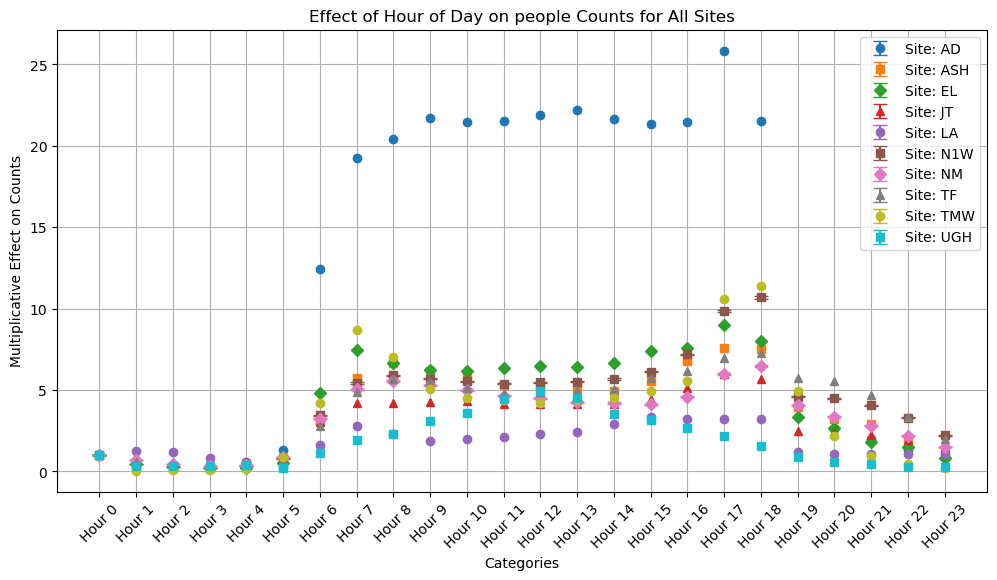

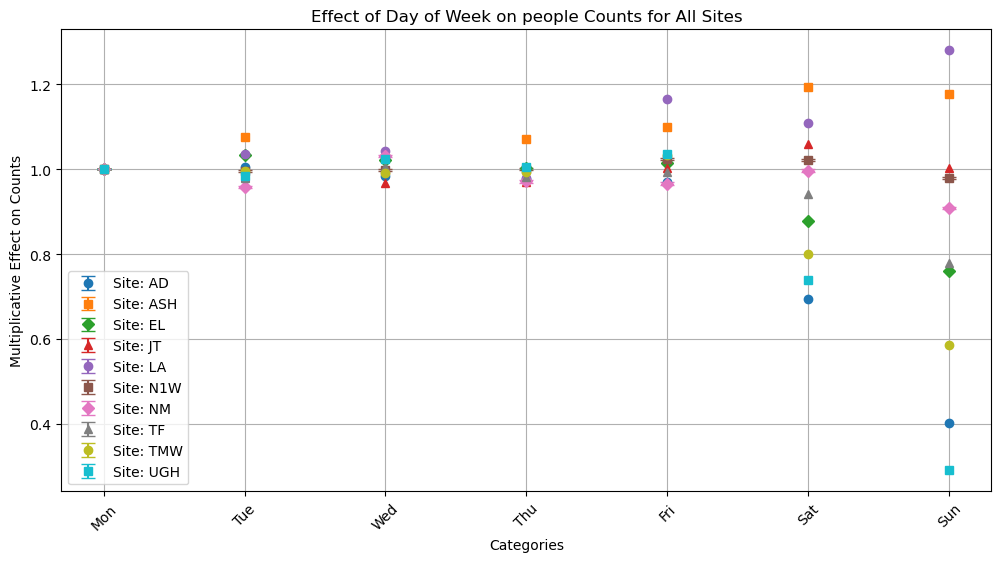

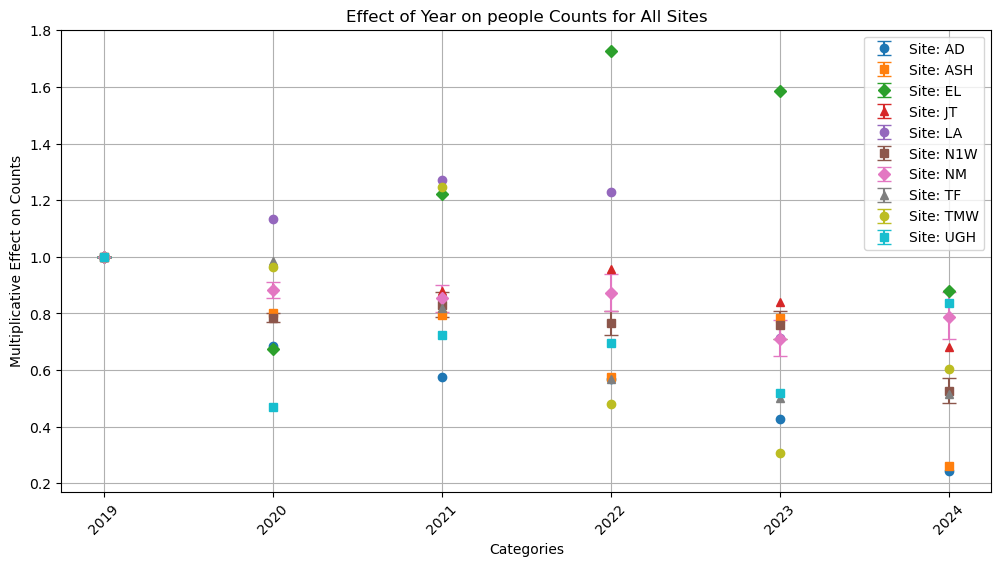

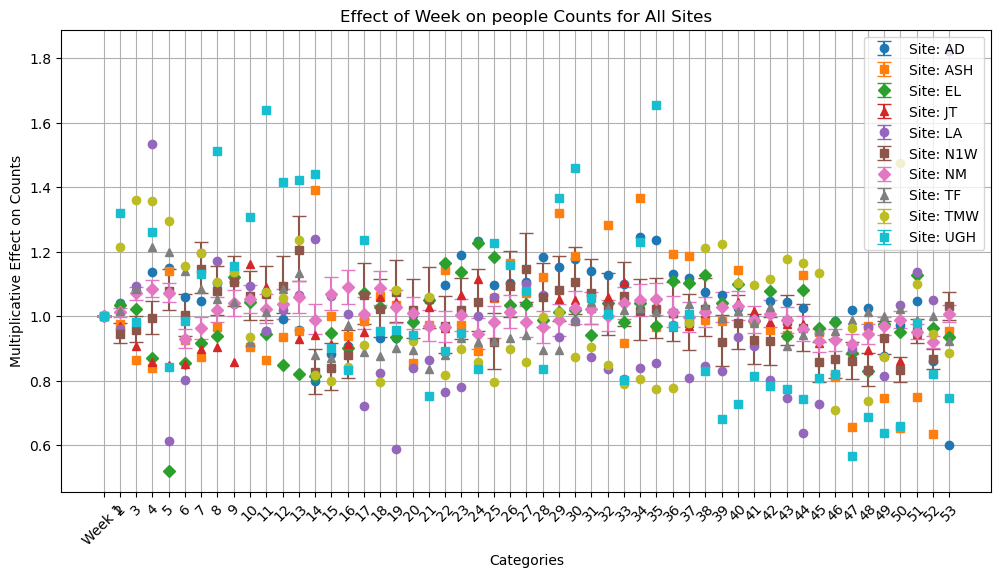

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Function to calculate the confidence intervals and exponentiate the coefficients
def calculate_effects_and_ci(glm_result, var):
    coef = glm_result.params[var]
    conf = glm_result.conf_int().loc[var]
    lower, upper = conf
    return np.exp(coef), np.exp(lower), np.exp(upper)

# Function to plot effects for all sites
def plot_effects_multiple_sites(site_results, var, x_labels, title, ref_class_label):
    plt.figure(figsize=(12, 6))
    
    for i, (site, result) in enumerate(site_results.items()):
        # if site != 'EL':
        if site != None:
            # Filter out variables that are not present in the current result
            available_vars = [v for v in var if v in result.params.index]
            if not available_vars:
                continue  # Skip this site if no variables are available
            
            effects = [calculate_effects_and_ci(result, v) for v in available_vars]
            estimates, lower_bounds, upper_bounds = zip(*effects)
            
            # Adjust x_labels to match the filtered variables
            filtered_labels = [x_labels[var.index(v)] for v in available_vars]
            
            # Add the reference class at the start
            estimates = [1] + list(estimates)
            lower_bounds = [1] + list(lower_bounds)
            upper_bounds = [1] + list(upper_bounds)
            x_labels_mod = [ref_class_label] + filtered_labels
            
            plt.errorbar(
                range(len(x_labels_mod)), 
                estimates, 
                yerr=[np.array(estimates) - np.array(lower_bounds), np.array(upper_bounds) - np.array(estimates)], 
                fmt=f'{["o", "s", "D", "^"][i % 4]}', 
                label=f'Site: {site}',
                capsize=5
            )
    
    plt.xticks(ticks=range(len(x_labels_mod)), labels=x_labels_mod, rotation=45)
    plt.xlabel('Categories')
    plt.ylabel('Multiplicative Effect on Counts')
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()

# Variables to plot
hour_vars = [col for col in exog_fixed.columns if 'hour' in col and col != 'const']
day_vars = [col for col in exog_fixed.columns if 'day' in col and col != 'const']
year_vars = [col for col in exog_fixed.columns if 'year' in col and col != 'const']
week_vars = [col for col in exog_fixed.columns if 'week' in col and col != 'const'] if week_bool else []

# X-axis labels
hour_labels = [f'Hour {i}' for i in range(1, 24)]
day_labels = ['Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']  # Assuming 'Mon' is the reference category
year_labels = [label.split('_')[1] for label in year_vars]
week_labels = [label.split('_')[1] for label in week_vars]

# Ensure the number of labels matches the number of data points
assert len(hour_labels) == len(hour_vars)
assert len(day_labels) == len(day_vars)
assert len(year_labels) == len(year_vars)
if week_bool:
    assert len(week_labels) == len(week_vars)

# Plot effects for all sites
plot_effects_multiple_sites(site_results, hour_vars, hour_labels, 'Effect of Hour of Day on '+super_category+' Counts for All Sites', 'Hour 0')
plot_effects_multiple_sites(site_results, day_vars, day_labels, 'Effect of Day of Week on '+super_category+' Counts for All Sites', 'Mon')
plot_effects_multiple_sites(site_results, year_vars, year_labels, 'Effect of Year on '+super_category+' Counts for All Sites', '2019')

if week_bool:
    plot_effects_multiple_sites(site_results, week_vars, week_labels, 'Effect of Week on '+super_category+' Counts for All Sites', 'Week 1')


/tmp/ipykernel_5713/2427628312.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(12, 6))


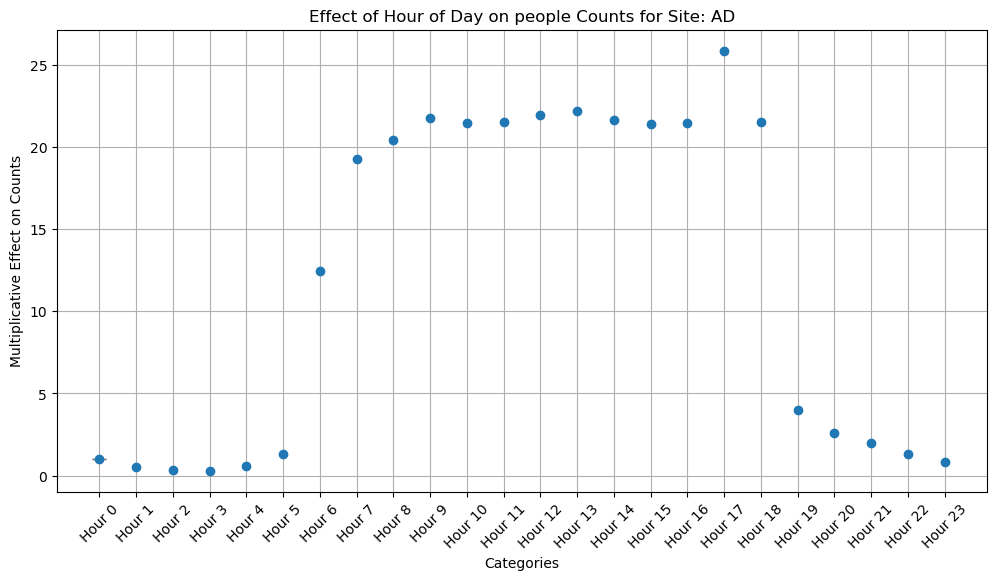

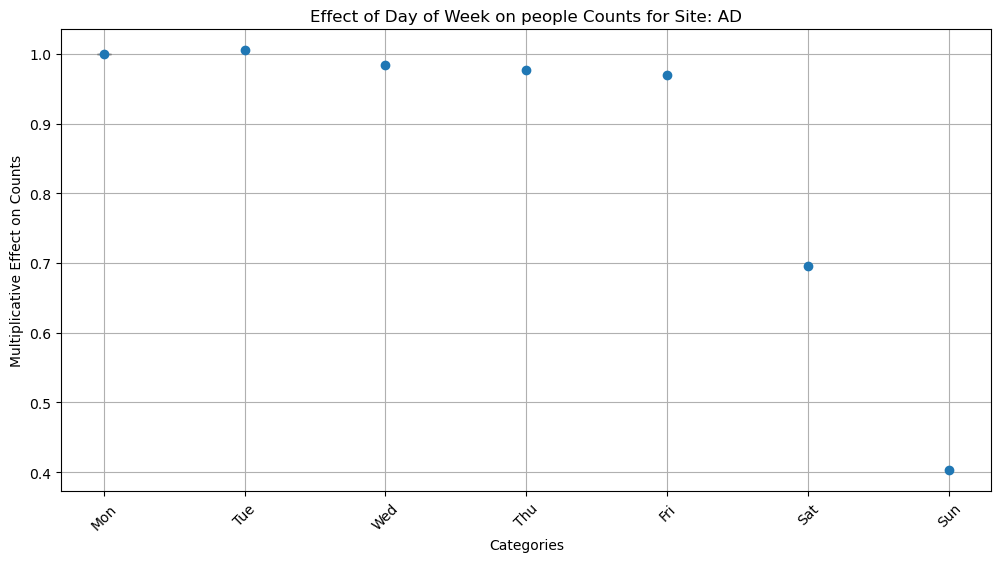

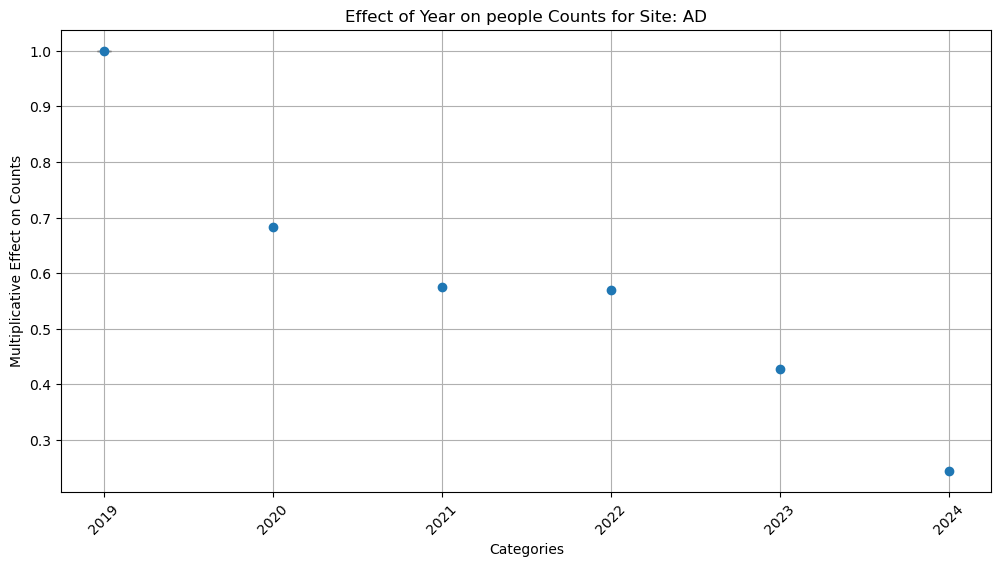

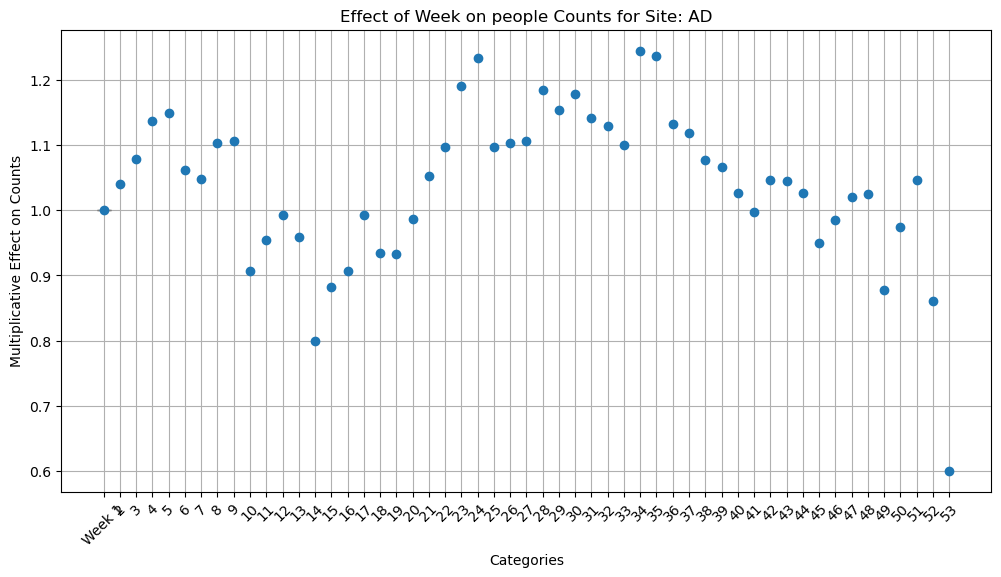

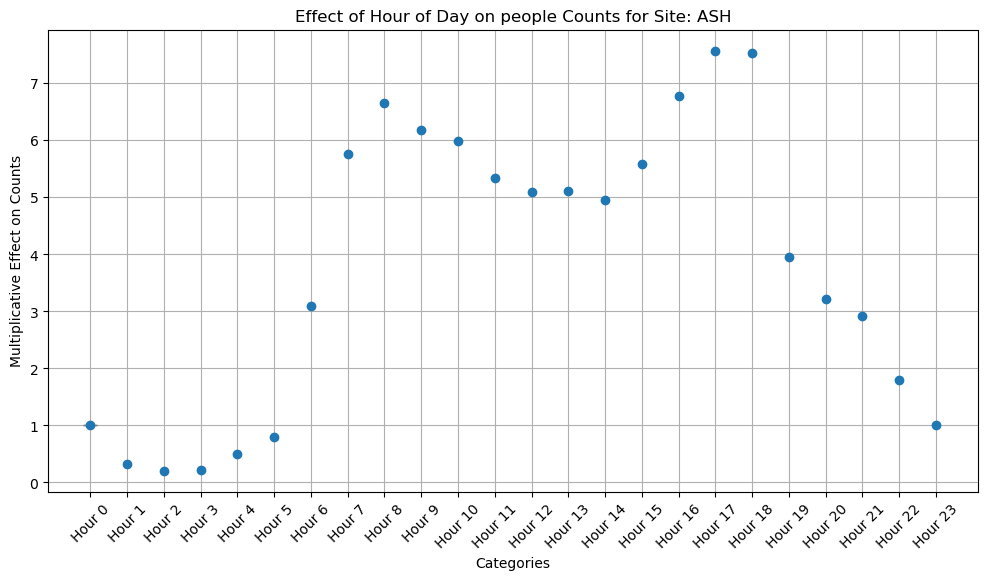

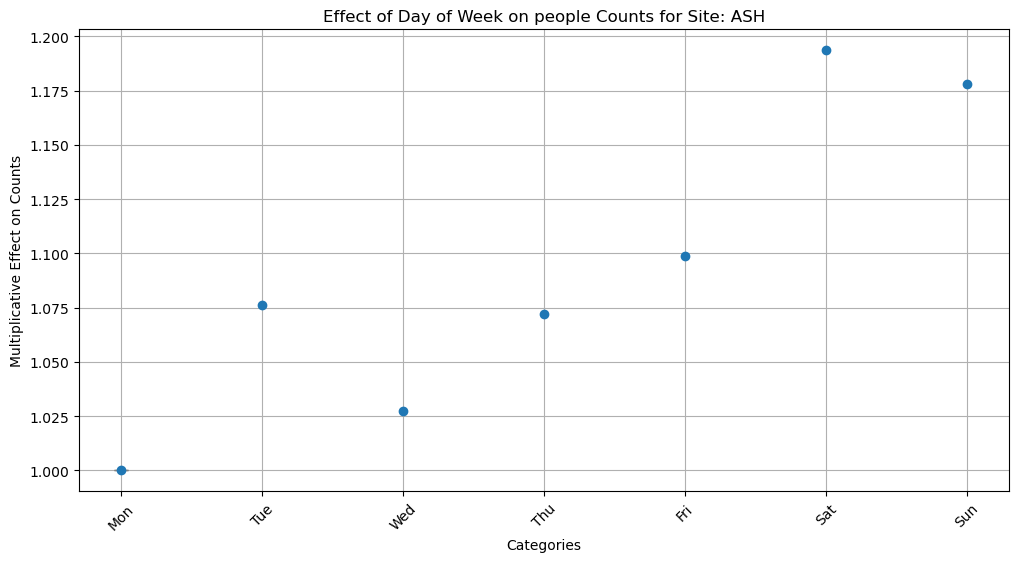

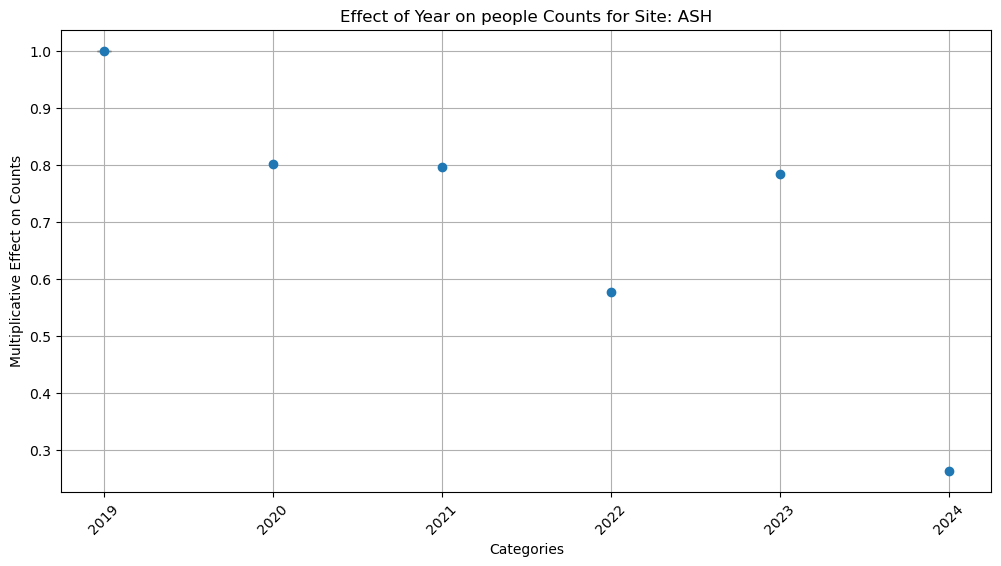

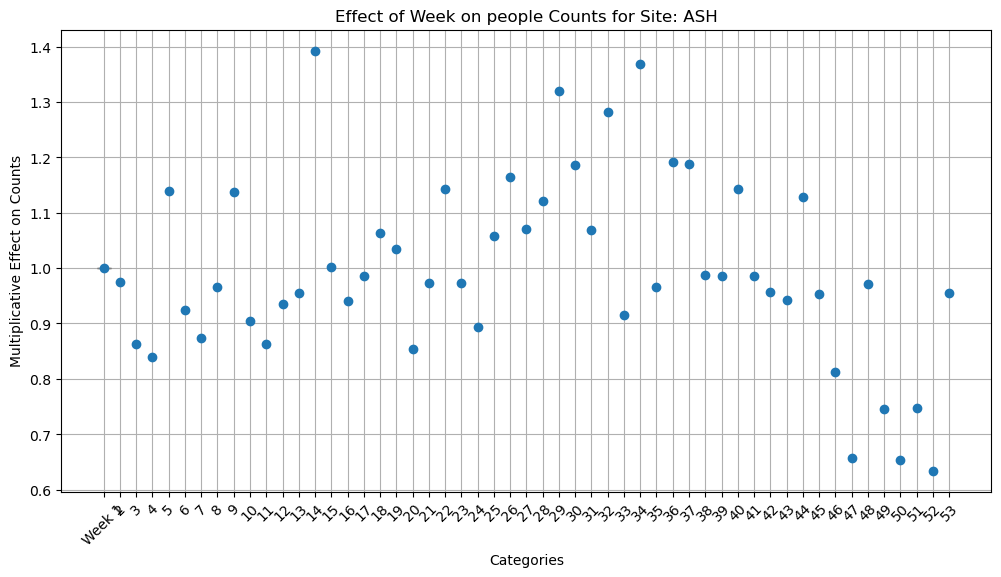

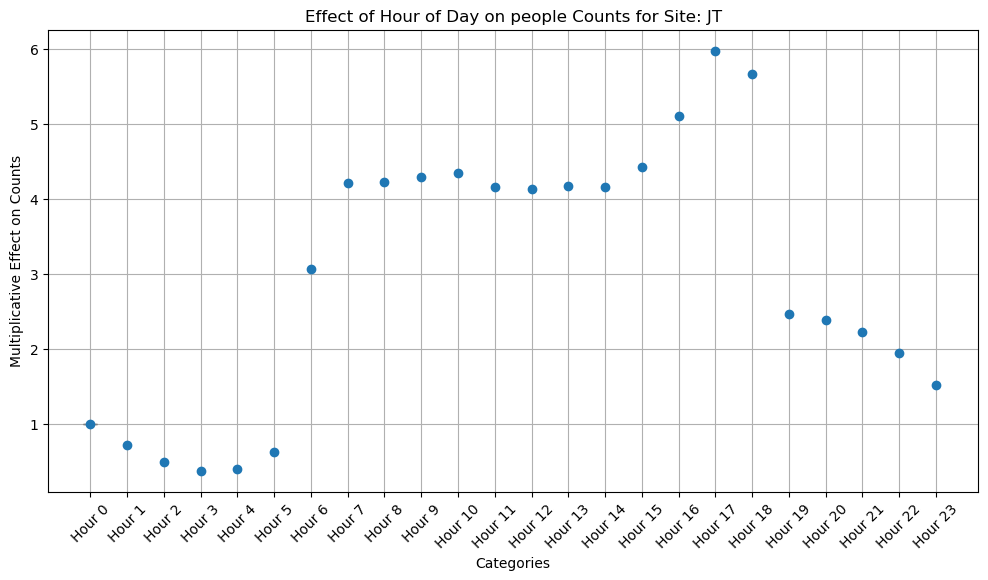

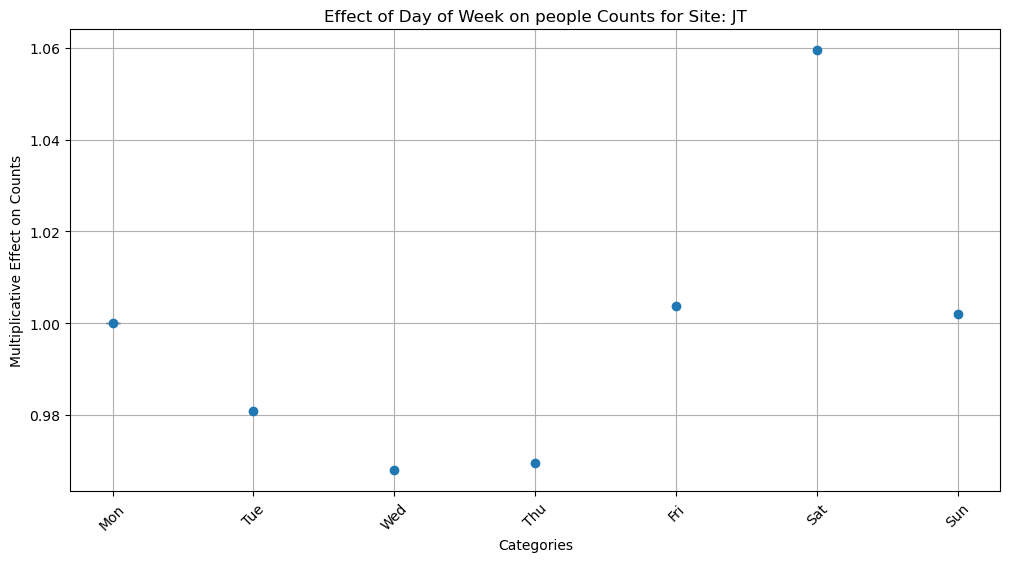

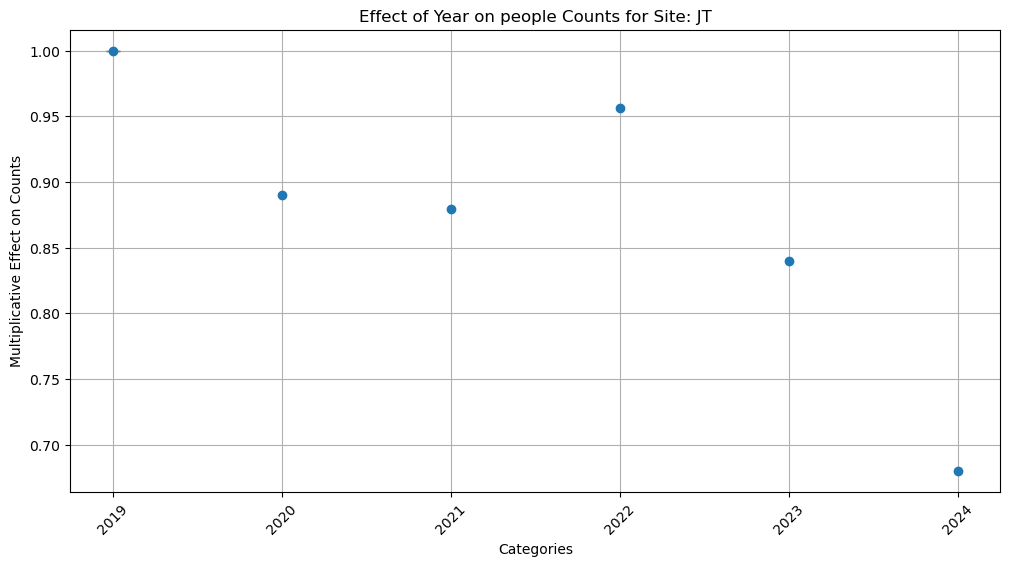

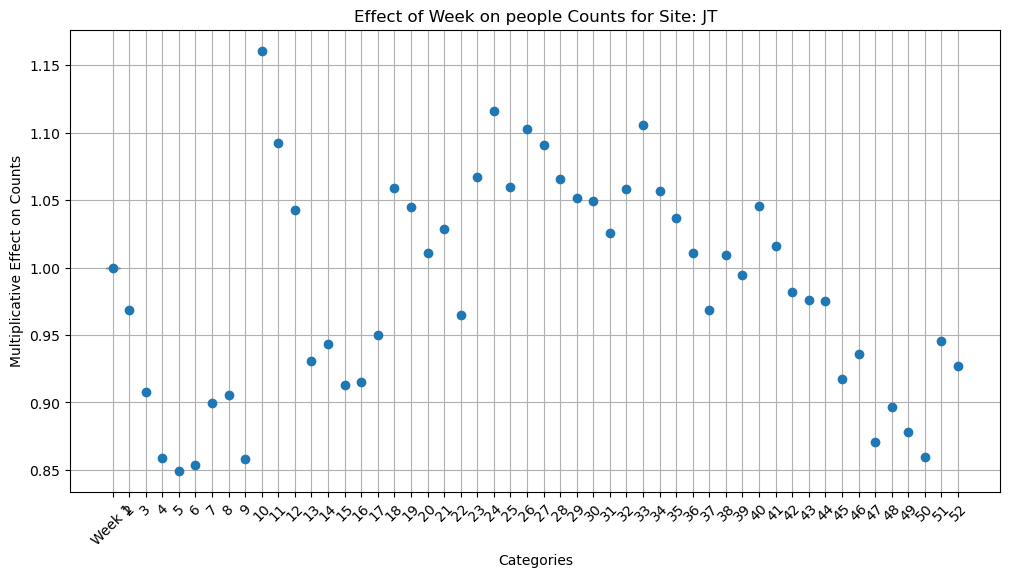

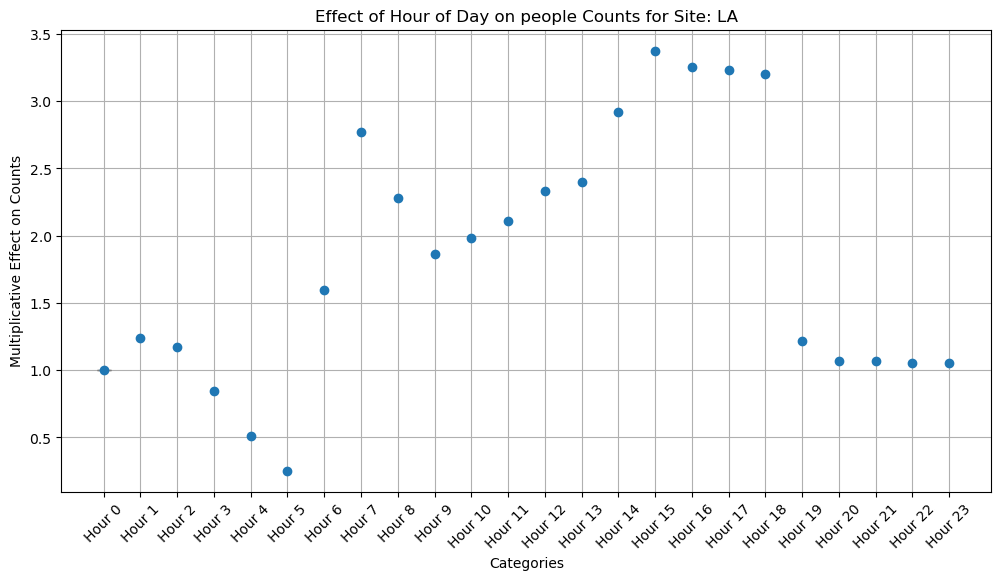

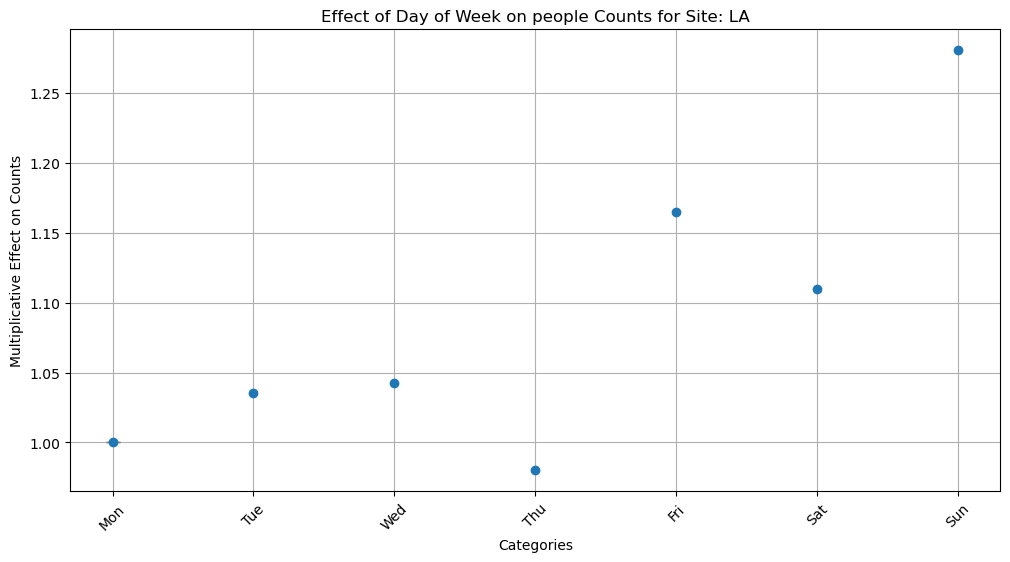

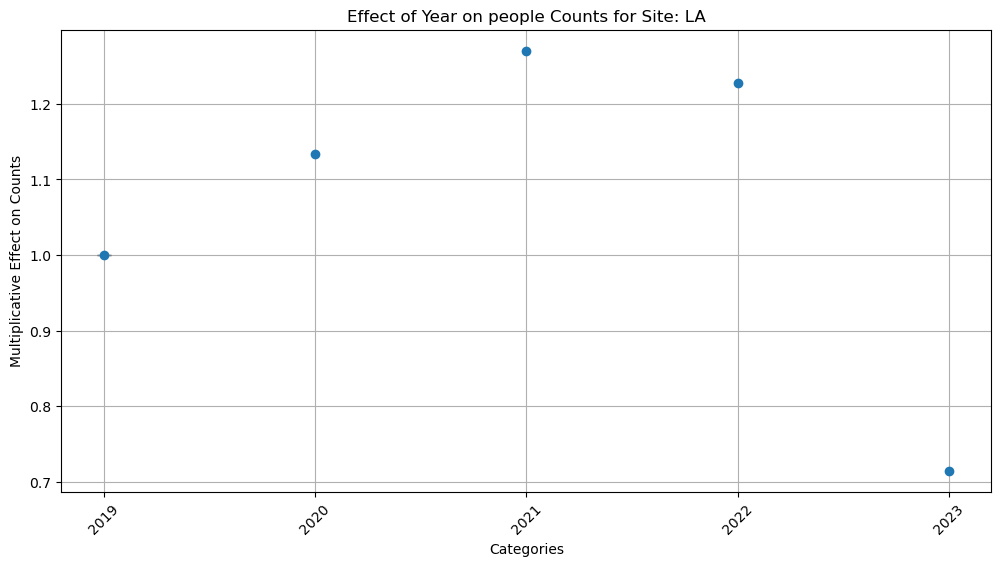

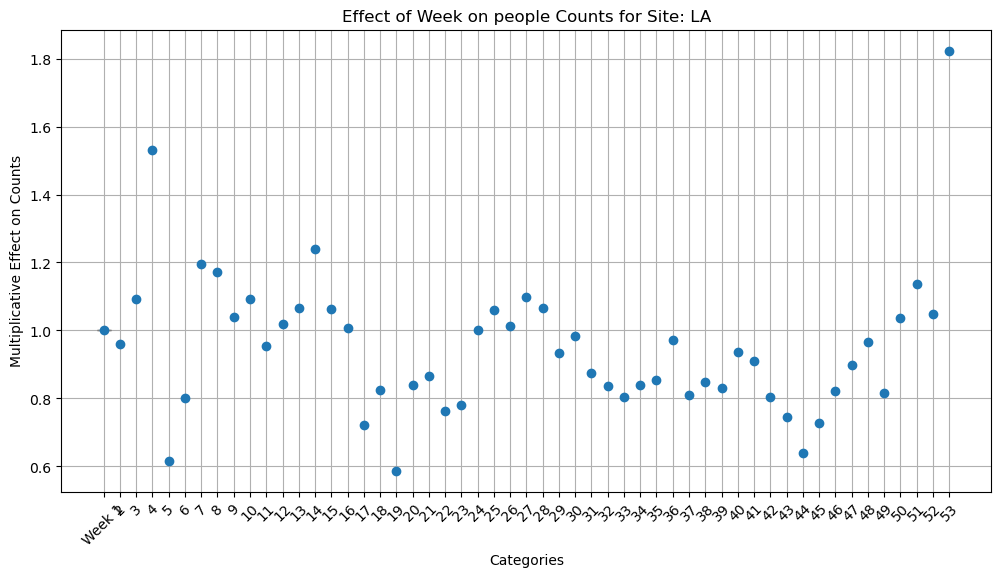

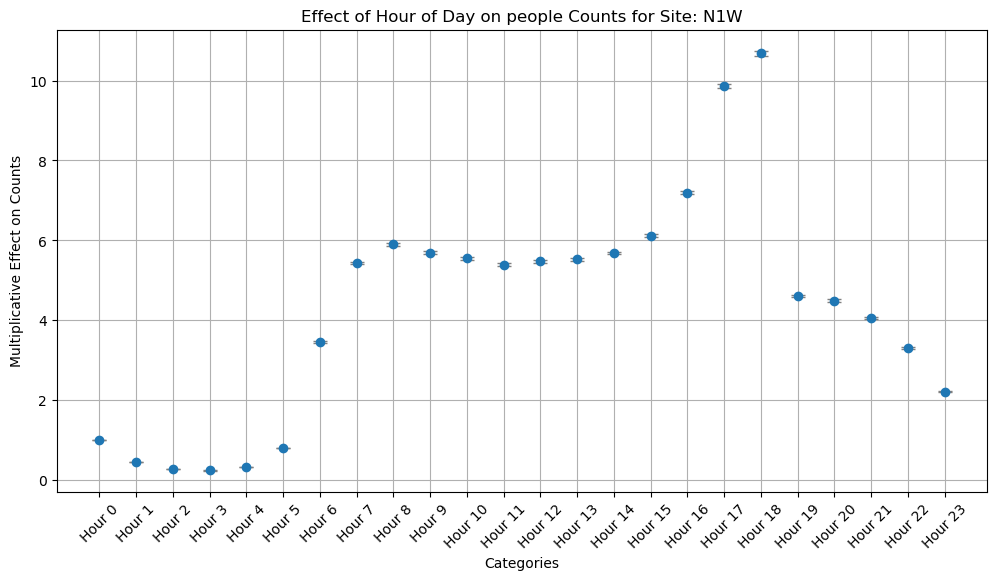

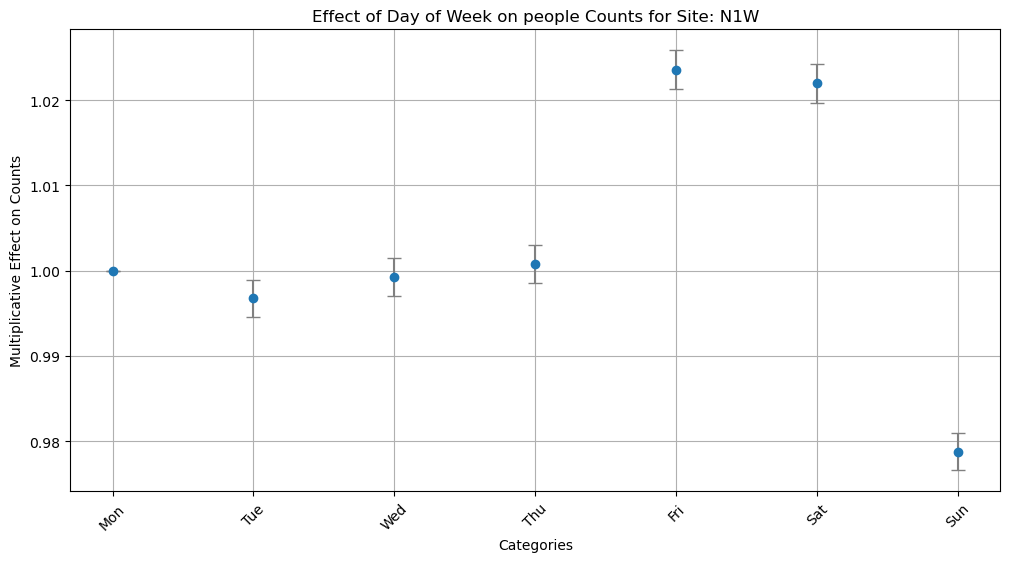

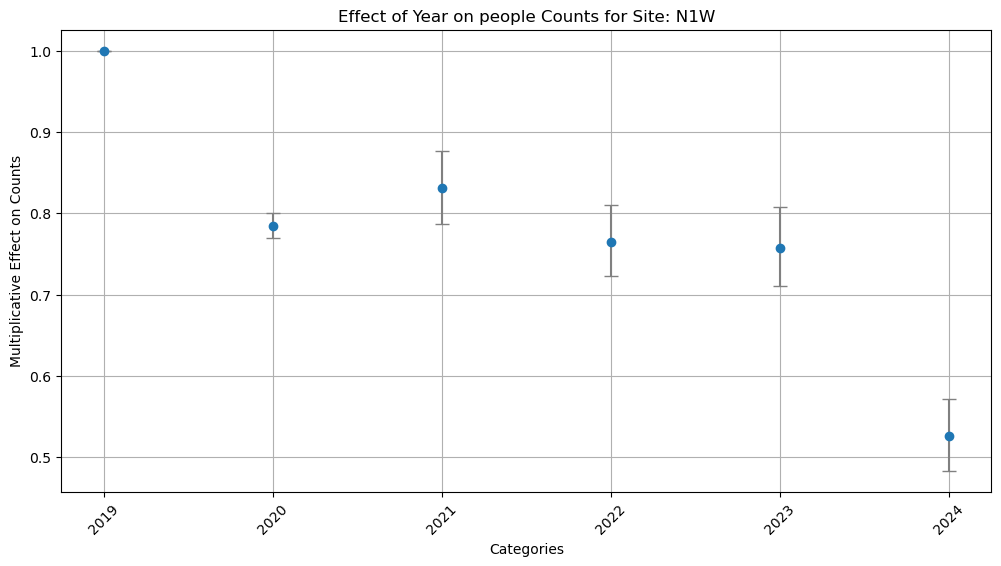

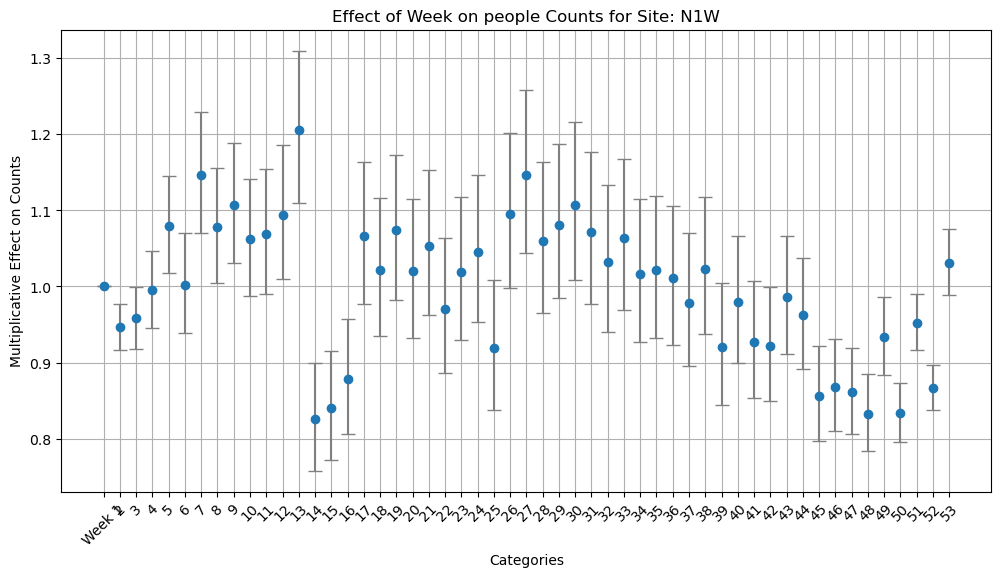

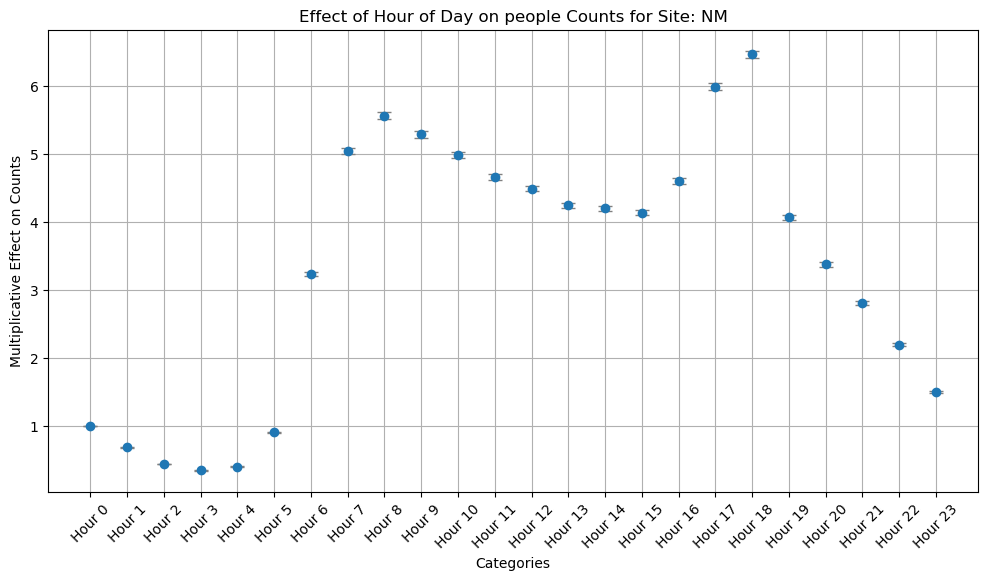

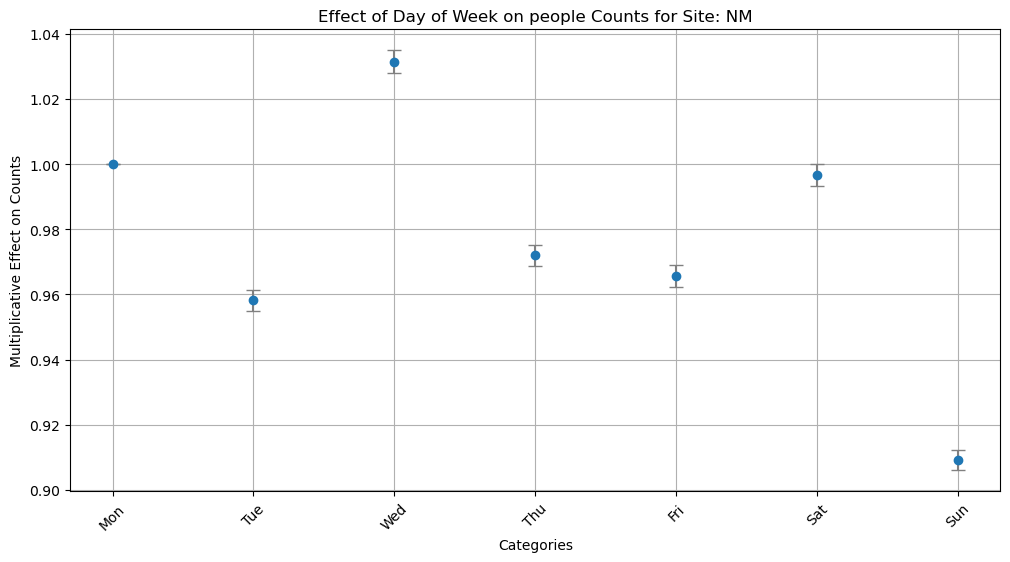

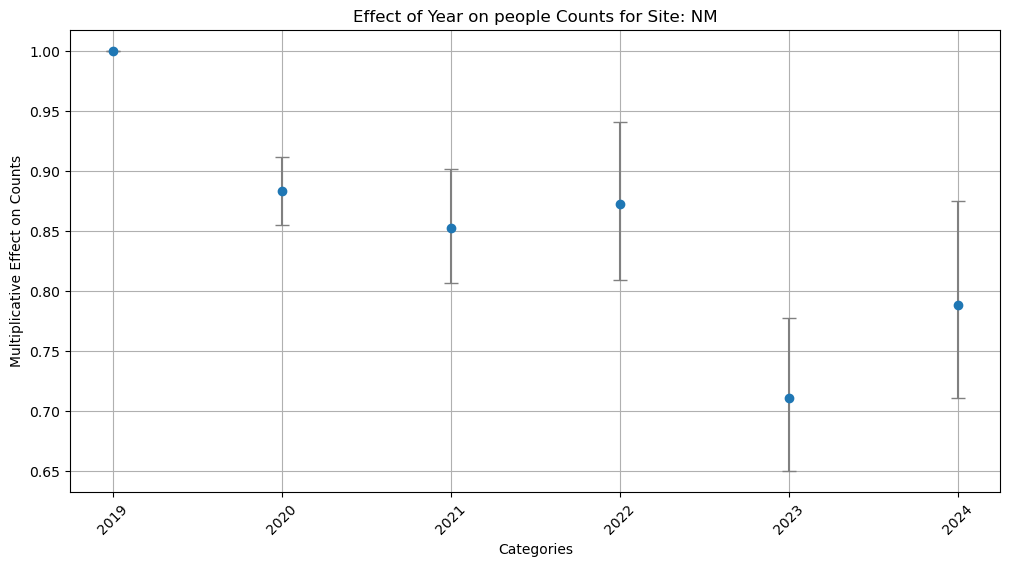

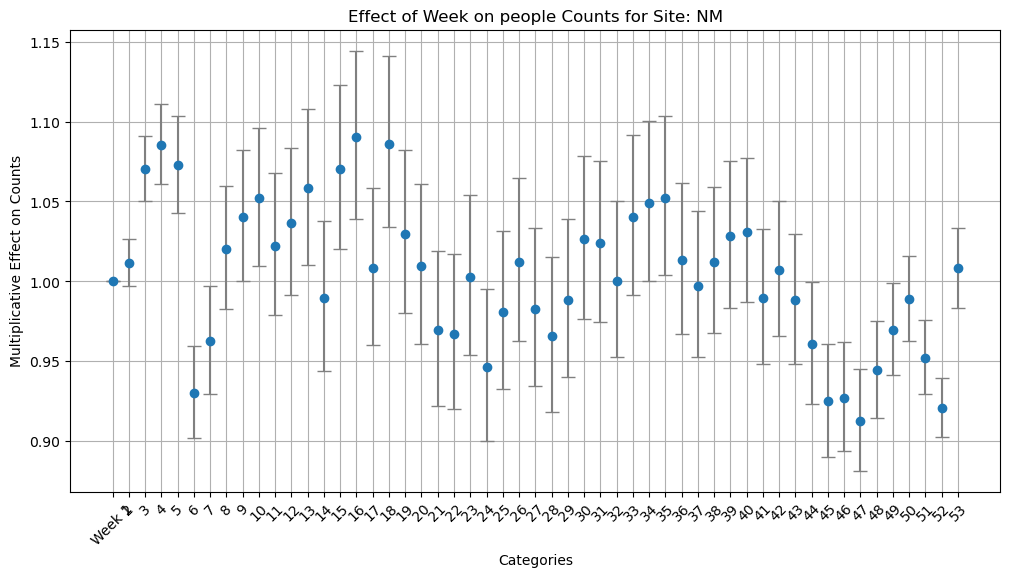

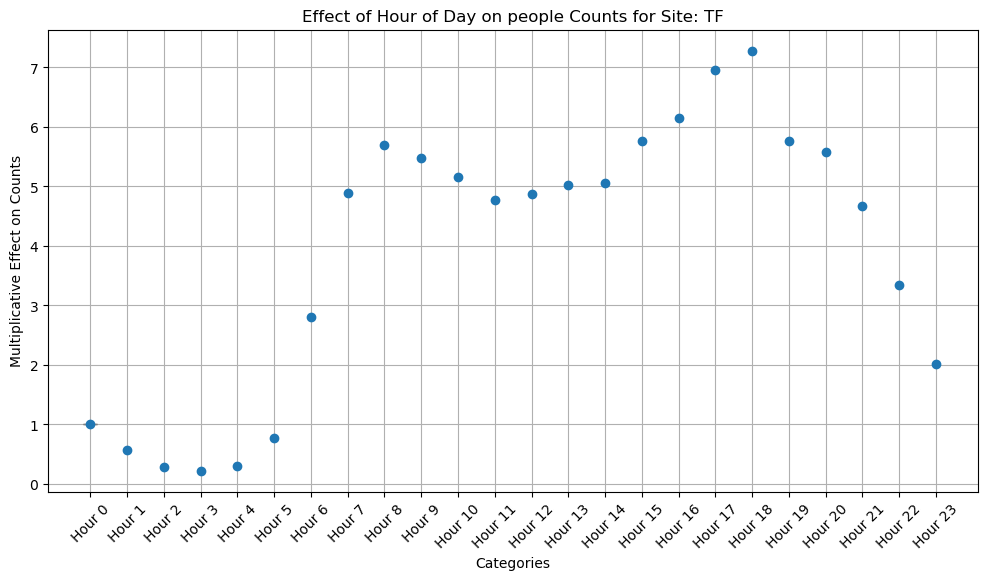

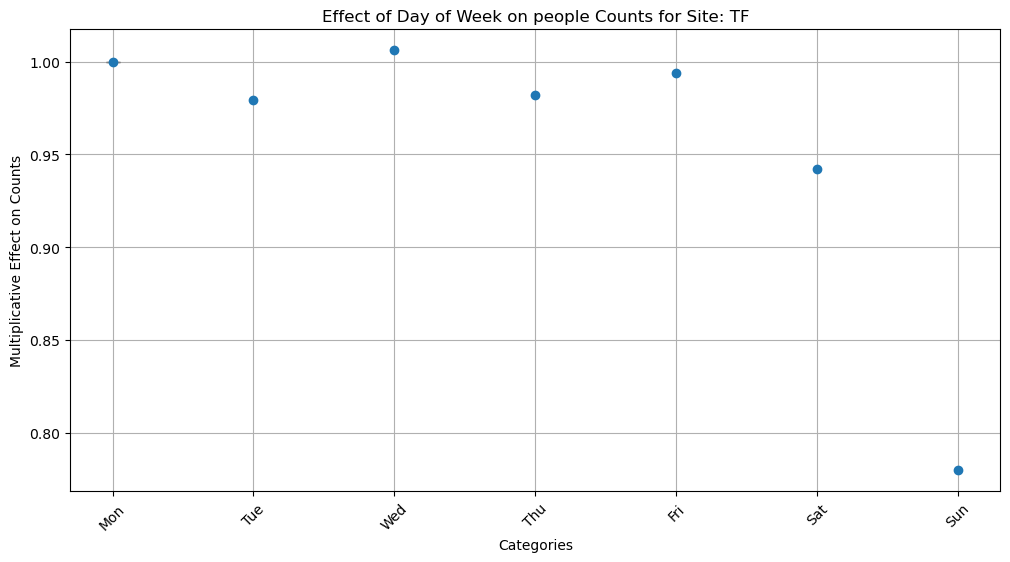

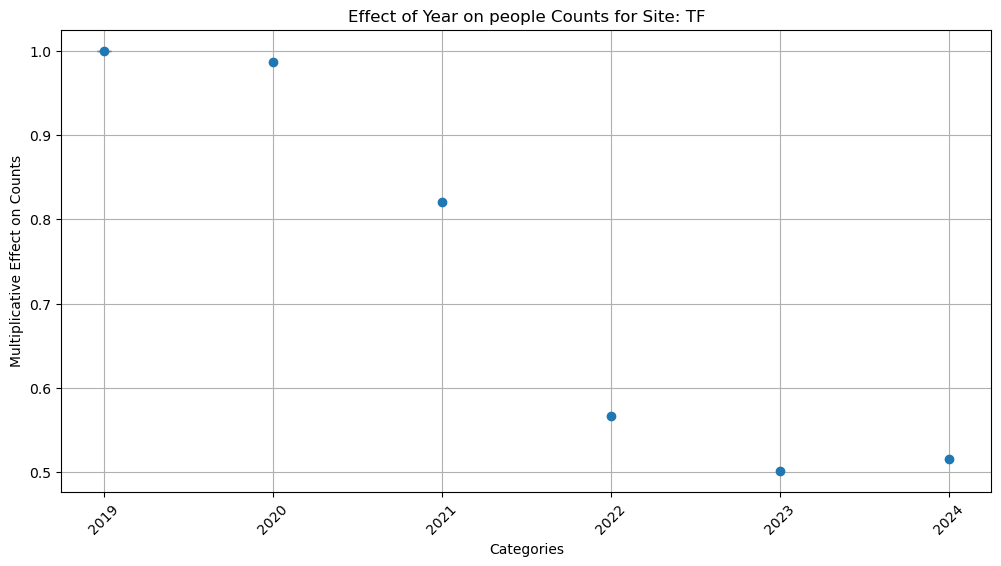

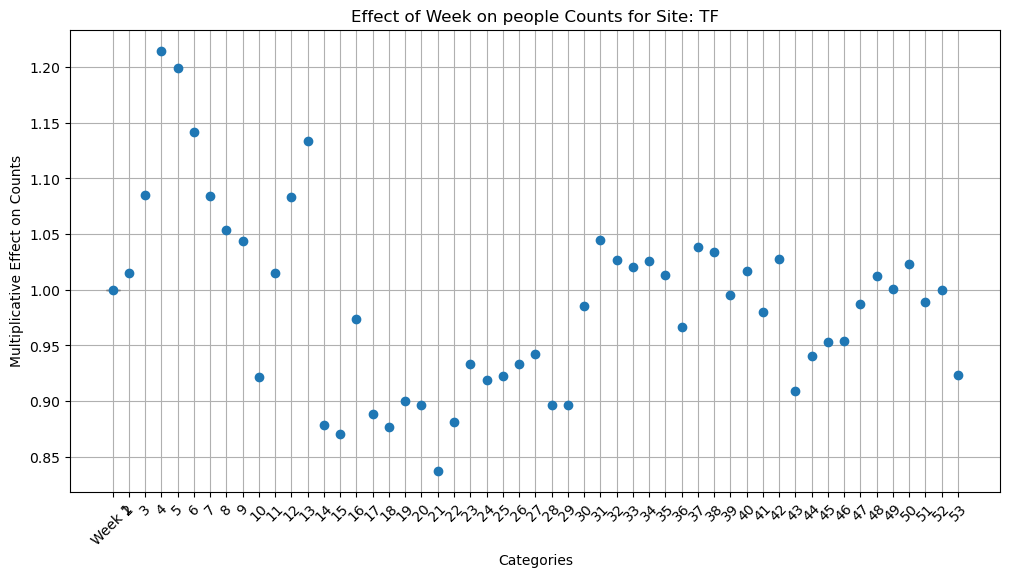

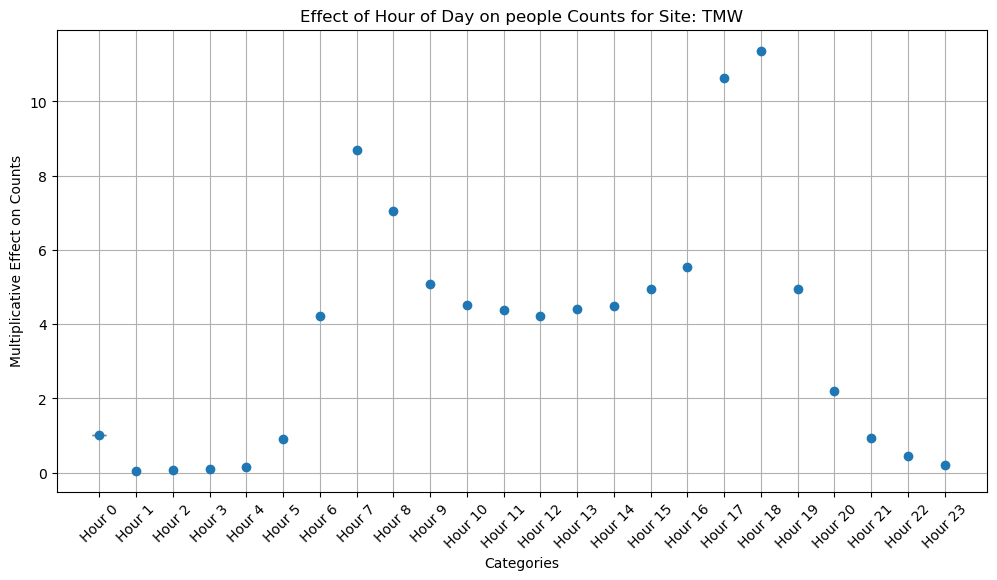

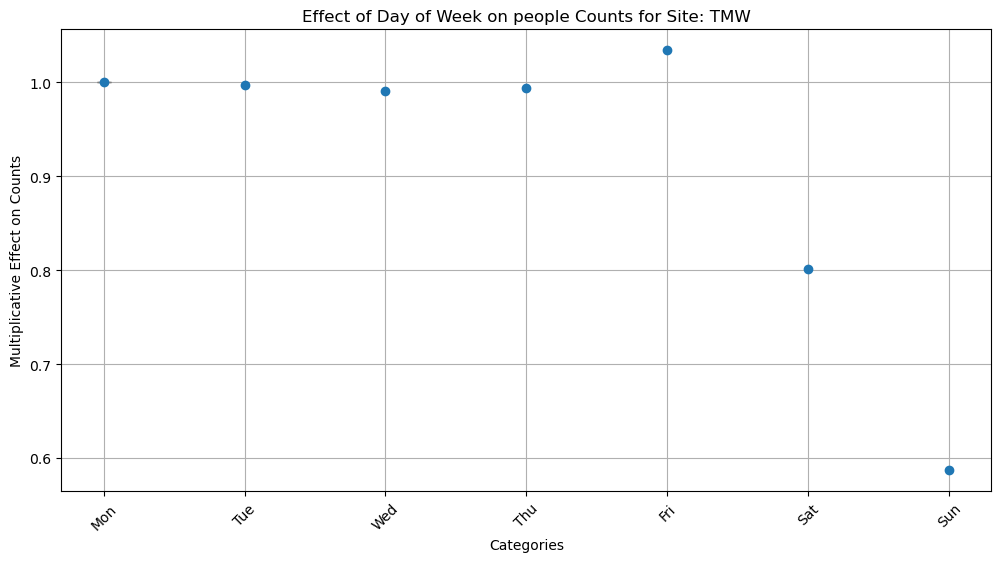

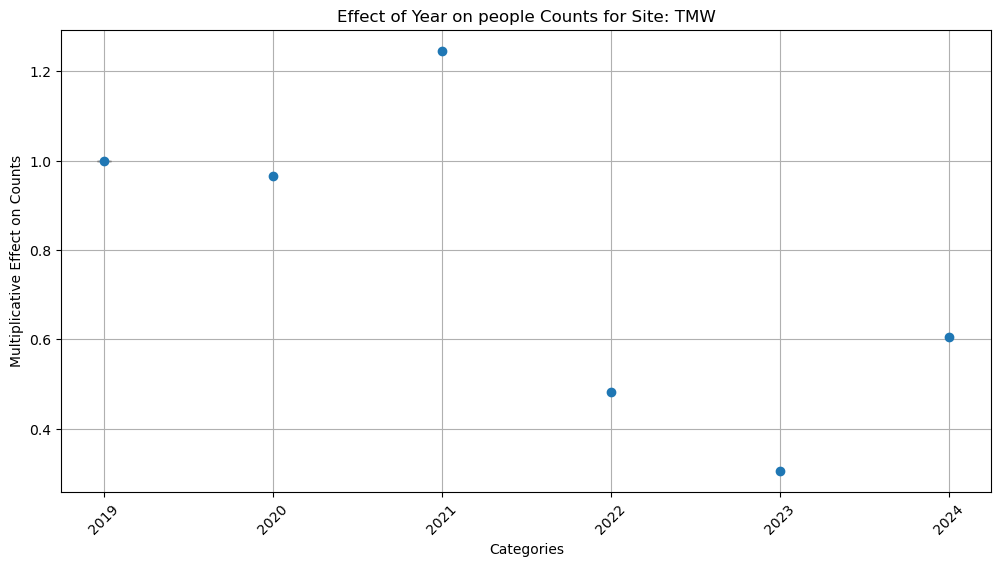

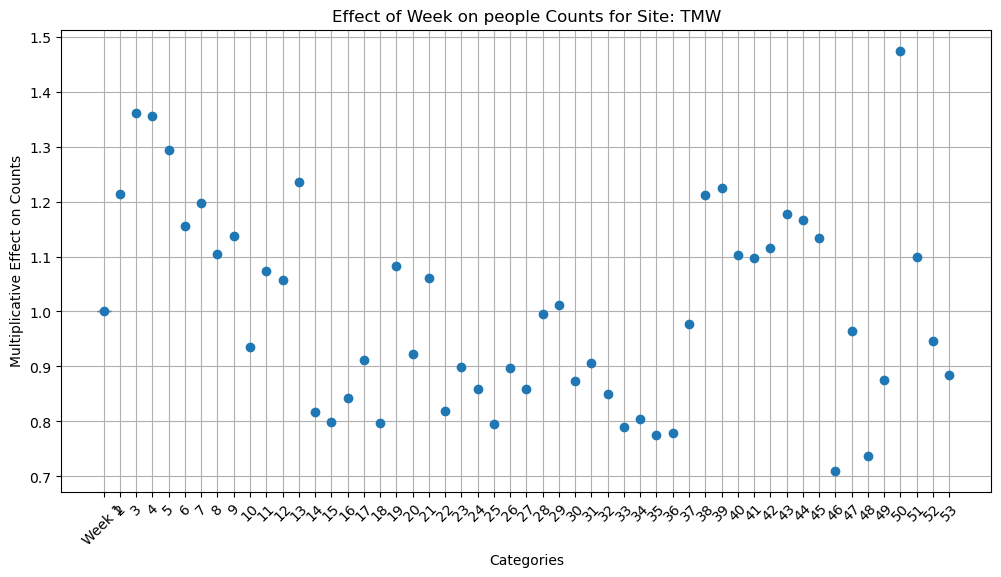

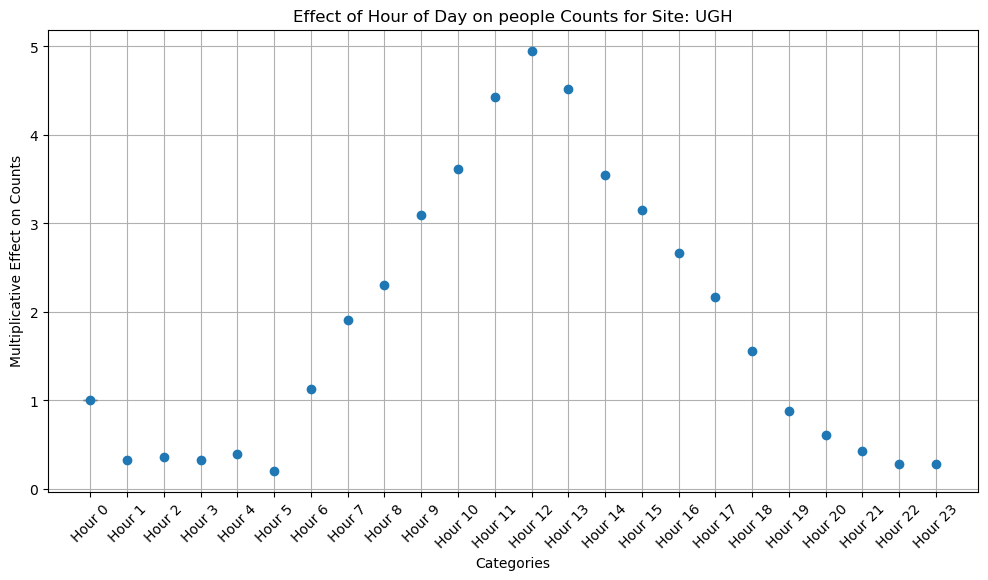

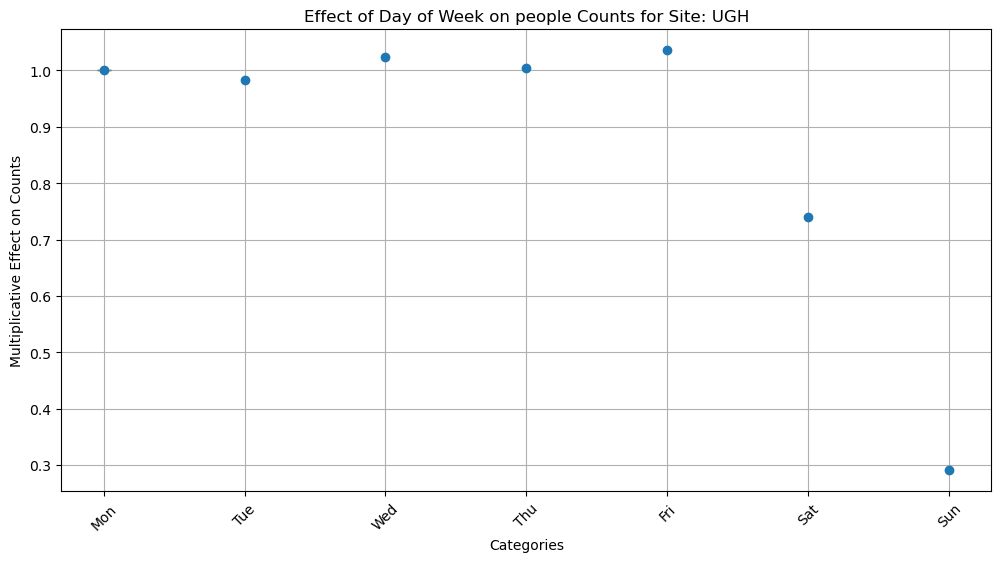

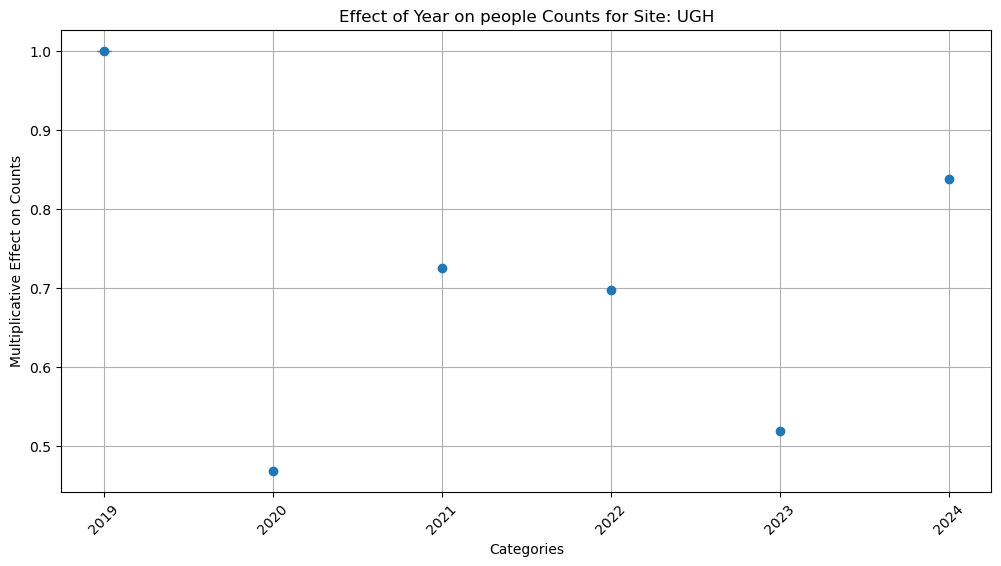

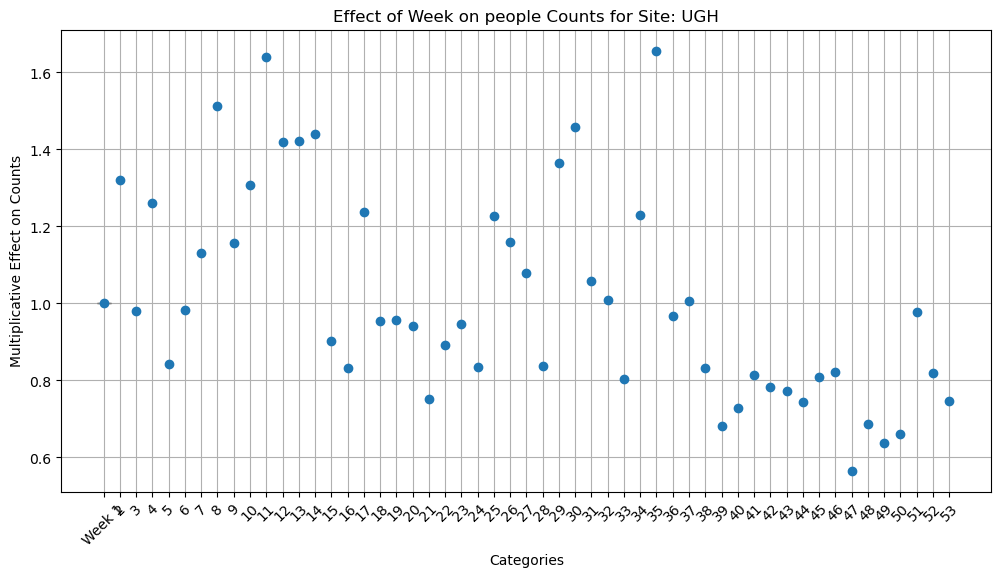

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Function to calculate the confidence intervals and exponentiate the coefficients
def calculate_effects_and_ci(glm_result, var):
    coef = glm_result.params[var]
    conf = glm_result.conf_int().loc[var]
    lower, upper = conf
    return np.exp(coef), np.exp(lower), np.exp(upper)

# Function to plot effects for a single site
def plot_effects_single_site(site, glm_result, var, x_labels, title, ref_class_label):
    available_vars = [v for v in var if v in glm_result.params.index]
    effects = [calculate_effects_and_ci(glm_result, v) for v in available_vars]
    
    # Filter x_labels based on available variables
    filtered_labels = [x_labels[var.index(v)] for v in available_vars]
    
    # Add the reference class at the start
    estimates = [1] + [e[0] for e in effects]
    lower_bounds = [1] + [e[1] for e in effects]
    upper_bounds = [1] + [e[2] for e in effects]
    filtered_labels = [ref_class_label] + filtered_labels
    
    plt.figure(figsize=(12, 6))
    plt.errorbar(
        range(len(filtered_labels)), 
        estimates, 
        yerr=[np.array(estimates) - np.array(lower_bounds), np.array(upper_bounds) - np.array(estimates)], 
        fmt='o', 
        ecolor='gray', 
        capsize=5
    )
    plt.xticks(ticks=range(len(filtered_labels)), labels=filtered_labels, rotation=45)
    plt.xlabel('Categories')
    plt.ylabel('Multiplicative Effect on Counts')
    plt.title(f"{title} for Site: {site}")
    plt.grid(True)
    plt.savefig('./results/time_series/'+site+'/'+super_category+'/'+title.replace(' ','_')+'.png', bbox_inches='tight')
    # plt.show()

# Variables to plot
hour_vars = [col for col in exog_fixed.columns if 'hour' in col and col != 'const']
day_vars = [col for col in exog_fixed.columns if 'day' in col and col != 'const']
year_vars = [col for col in exog_fixed.columns if 'year' in col and col != 'const']
week_vars = [col for col in exog_fixed.columns if 'week' in col and col != 'const'] if week_bool else []

# X-axis labels
hour_labels = [f'Hour {i}' for i in range(1, 24)]
day_labels = ['Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']  # Assuming 'Mon' is the reference category
year_labels = [label.split('_')[1] for label in year_vars]
week_labels = [label.split('_')[1] for label in week_vars]

# Ensure the number of labels matches the number of data points
assert len(hour_labels) == len(hour_vars)
assert len(day_labels) == len(day_vars)
assert len(year_labels) == len(year_vars)
if week_bool:
    assert len(week_labels) == len(week_vars)

# Plot effects for each site separately
for site, result in site_results.items():
    if site != 'EL':  # Skip the 'EL' site if necessary
        plot_effects_single_site(site, result, hour_vars, hour_labels, 'Effect of Hour of Day on '+super_category+' Counts', 'Hour 0')
        plot_effects_single_site(site, result, day_vars, day_labels, 'Effect of Day of Week on '+super_category+' Counts', 'Mon')
        plot_effects_single_site(site, result, year_vars, year_labels, 'Effect of Year on '+super_category+' Counts', '2019')
        
        if week_bool:
            plot_effects_single_site(site, result, week_vars, week_labels, 'Effect of Week on '+super_category+' Counts', 'Week 1')
